# 📓 03 Geoestadística y Análisis de Autocorrelación

Este notebook implementa el análisis de autocorrelación espacial global y local (Moran's I) utilizando PySAL.

In [1]:
import geopandas as gpd
import libpysal
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

load_dotenv("../.env")
db_url = f"postgresql://{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}@{os.getenv('POSTGRES_HOST', 'localhost')}:5432/{os.getenv('POSTGRES_DB')}"
engine = create_engine(db_url)

## 1. Carga de Grilla de Densidad

Cargamos la grilla generada con el script `spatial_analysis.py` que ya contiene los datos de densidad y clusters.

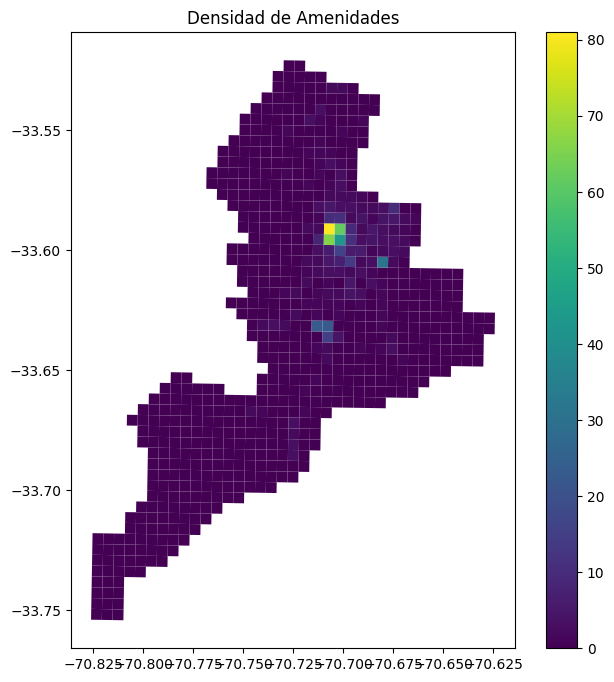

In [2]:
grid = gpd.read_postgis("SELECT * FROM raw_data.amenity_clusters", engine, geom_col='geometry')
grid.plot(column='count', cmap='viridis', legend=True, figsize=(8, 8))
plt.title("Densidad de Amenidades")
plt.show()

## 2. Visualización de Clusters LISA

Analizamos las agrupaciones espaciales estadísticamente significativas.

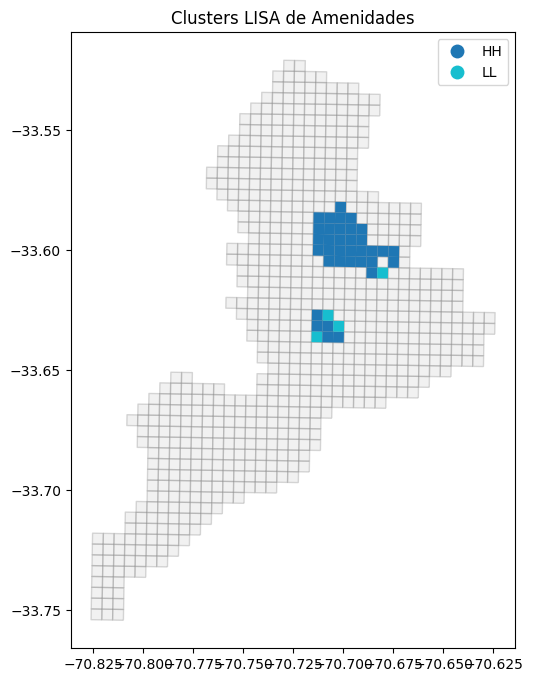

In [3]:
fig, ax = plt.subplots(figsize=(10, 8))
grid.plot(ax=ax, color='lightgrey', edgecolor='grey', alpha=0.3)
grid[grid.lisa_cluster != 0].plot(ax=ax, column='cluster_type', legend=True, categorical=True)
plt.title("Clusters LISA de Amenidades")
plt.show()